In [1]:
from create_dataset import CreateDataset
from train_models import ClassifierTrainer, RegressorTrainer
from callbacks import EarlyStoppingCallback, ReduceLROnPlateauCallback, ModelCheckpointCallback

/Users/aleksejkitajskij/Desktop/DS-Lifehacks/pytorch/train_models.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## binary classification

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/Module_1_Lecture_2_Class_Spaceship_Titanic.csv')
df = df.set_index('PassengerId')

TARGET = 'Transported'
FEATURES = [col for col in df.columns if col != TARGET]

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(df[imputer_cols])
df[imputer_cols] = imputer.transform(df[imputer_cols])

df["HomePlanet"].fillna('Gallifrey', inplace=True)
df["Destination"].fillna('Skaro', inplace=True)

df['CryoSleep_is_missing'] = df['CryoSleep'].isna().astype(int)
df['VIP_is_missing'] = df['VIP'].isna().astype(int)

df["CryoSleep"].fillna(False, inplace=True)
df["VIP"].fillna(False, inplace=True)

df["CryoSleep"] = df["CryoSleep"].astype(int)
df["VIP"] = df["VIP"].astype(int)

dummies = pd.get_dummies(df.loc[:, ['HomePlanet', 'Destination']], dtype=int)

df = pd.concat([df, dummies], axis=1)
df.drop(columns=['HomePlanet', 'Destination'], inplace=True)

df[TARGET] = df[TARGET].astype(int)

df.drop(["Name" ,"Cabin"] , axis=1 ,inplace = True)

In [4]:
X = df.drop(TARGET , axis =1 ).values
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.33, stratify = y)

In [5]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=len(X_train),
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=len(X_test),
                              num_workers=0
                             )

In [6]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [7]:
input_dim = X_train.shape[1]
model = Net(input_dim)
parameters = list(model.parameters())

criterion = nn.BCELoss()
optimizer = optim.SGD(parameters, lr=0.01)

In [8]:
early_stop = EarlyStoppingCallback(
    patience=10,
    min_delta=0.001,
)

reduce_lr = ReduceLROnPlateauCallback(optimizer=optimizer,
                                      patience=5, 
                                      factor=0.5,
                                      min_delta=0.01)

best_model = ModelCheckpointCallback(path='best_model.pt', min_delta=0.1)

callbacks = [early_stop, reduce_lr, best_model]

In [9]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=2,
                            device='cpu',
                            callbacks=callbacks)

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=100,
            info_every_iter=10,
            show_val_metrics=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/100] Train Loss: 0.6782 Acc: 0.5792 Rec: 0.4316 Prec: 0.6176


Epoch [20/100] Train Loss: 0.6760 Acc: 0.5841 Rec: 0.4412 Prec: 0.6230


Epoch [30/100] Train Loss: 0.6754 Acc: 0.5852 Rec: 0.4432 Prec: 0.6241


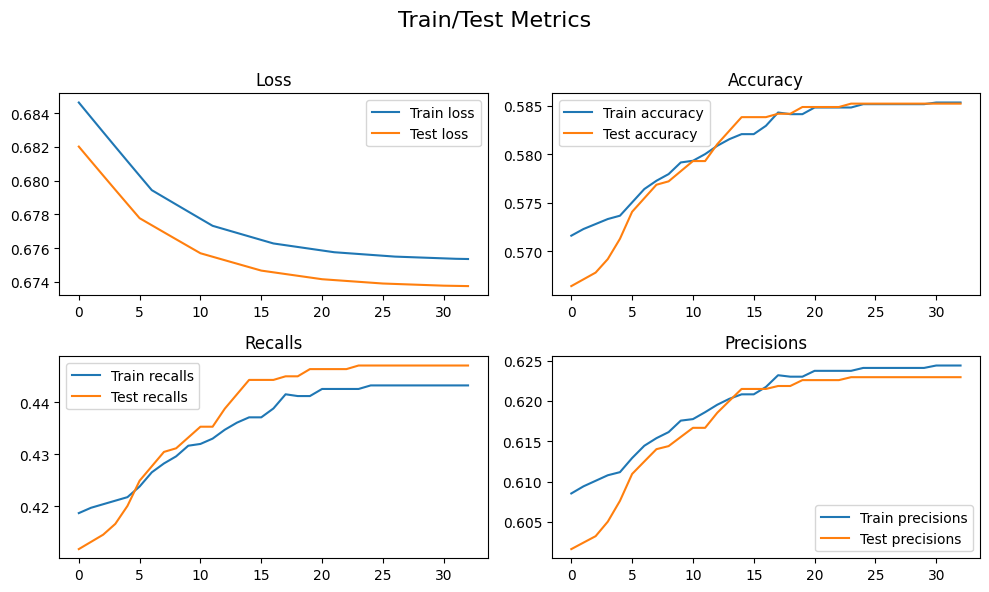

In [10]:
trainer.plot_metrics()

## multyclass classification

In [11]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('data/Module_2_Lecture_2_Class_penguins.csv')
df = df.dropna().reset_index(drop=True)
features = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
df = df.loc[:, features]
df.loc[df['species']=='Adelie', 'species']=0
df.loc[df['species']=='Gentoo', 'species']=1
df.loc[df['species']=='Chinstrap', 'species']=2
df = df.apply(pd.to_numeric)

In [13]:
X = df.drop('species', axis =1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.33, stratify=y)

X_train = torch.Tensor(X_train).float()
y_train = torch.Tensor(y_train).long()
X_test = torch.Tensor(X_test).float()
y_test = torch.Tensor(y_test).long()

In [14]:
train_dataset = CreateDataset(X_train, y_train, scaler='StandardScaler')
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [15]:
num_classes = len(np.unique(y_train))
num_classes

3

In [16]:
class Net(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=20, out_dim=3):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            
            nn.Linear(in_dim, hidden_dim),
            torch.nn.ReLU(),
            
            nn.Linear(hidden_dim, out_dim),
            nn.Softmax()
        )    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [17]:
model = Net(X_train.shape[1], 20, num_classes)
parameters = list(model.parameters())

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(parameters, lr=0.01)

In [18]:
early_stop = EarlyStoppingCallback(
    patience=10,
    min_delta=0.001,
)

reduce_lr = ReduceLROnPlateauCallback(optimizer=optimizer,
                                      patience=5, 
                                      factor=0.5,
                                      min_delta=0.01)

best_model = ModelCheckpointCallback(path='best_model.pt', min_delta=0.1)

callbacks = [early_stop, reduce_lr, best_model]

In [19]:
trainer = ClassifierTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_classes=num_classes,
                            device='mps',
                            callbacks=callbacks)

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=100,
            info_every_iter=10,
            show_val_metrics=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/100] Train Loss: 1.0019 Acc: 0.7481 Rec: 0.7481 Prec: 0.9141


Epoch [20/100] Train Loss: 0.9115 Acc: 0.7407 Rec: 0.7407 Prec: 0.9040


Epoch [30/100] Train Loss: 0.8329 Acc: 0.7556 Rec: 0.7556 Prec: 0.9063
Epoch [40/100] Train Loss: 0.7778 Acc: 0.8000 Rec: 0.8000 Prec: 0.9193


Epoch [50/100] Train Loss: 0.7398 Acc: 0.8370 Rec: 0.8370 Prec: 0.9338
Epoch [60/100] Train Loss: 0.7113 Acc: 0.8519 Rec: 0.8519 Prec: 0.9401
Epoch [70/100] Train Loss: 0.6883 Acc: 0.8667 Rec: 0.8667 Prec: 0.9466


Epoch [80/100] Train Loss: 0.6724 Acc: 0.9185 Rec: 0.9185 Prec: 0.9664


Epoch [90/100] Train Loss: 0.6676 Acc: 0.9185 Rec: 0.9185 Prec: 0.9664


Epoch [100/100] Train Loss: 0.6664 Acc: 0.9185 Rec: 0.9185 Prec: 0.9664


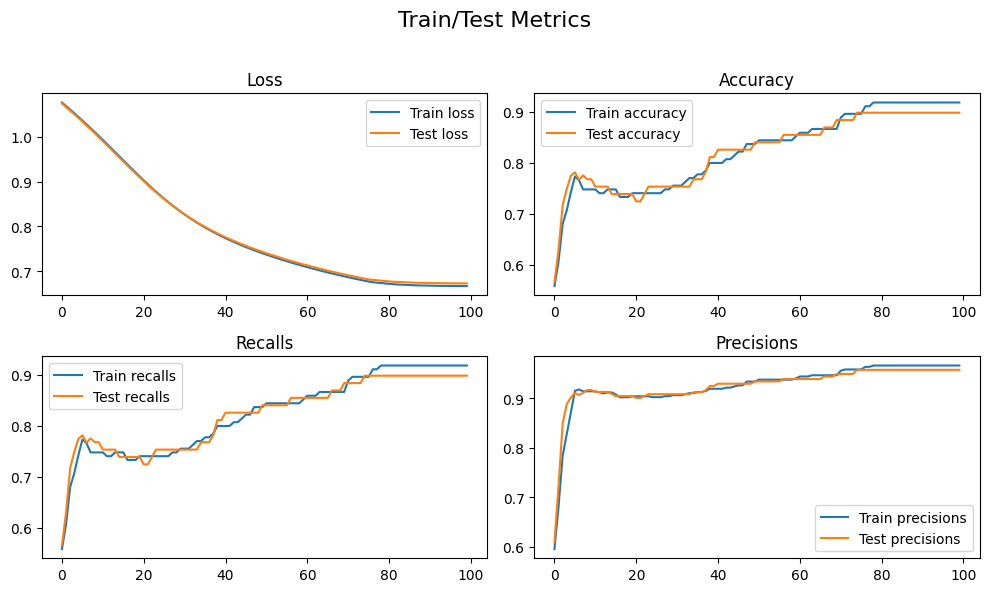

In [20]:
trainer.plot_metrics()

## regression

In [21]:
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [22]:
data_path = 'data/Module_2_Lecture_2_Class_bigmart_data.csv'
data = pd.read_csv(data_path)
data['Outlet_Establishment_Year'] = 2013 - data['Outlet_Establishment_Year']
data['Item_Visibility'] = (data['Item_Visibility']
                           .mask(data['Item_Visibility'].eq(0), np.nan))

data['Item_Visibility_Avg'] = (data
                               .groupby(['Item_Type',
                                         'Outlet_Type'])['Item_Visibility']
                               .transform('mean'))

data['Item_Visibility'] = (
    data['Item_Visibility'].fillna(data['Item_Visibility_Avg']))

data['Item_Visibility_Ratio'] = (
    data['Item_Visibility'] / data['Item_Visibility_Avg'])

data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'})

data['Item_Identifier_Type'] = data['Item_Identifier'].str[:2]
data_num = data.select_dtypes(include=np.number)
data_cat = data.select_dtypes(include='object')

In [23]:
X_train_num, X_test_num, X_train_cat,  X_test_cat, y_train, y_test = (
    train_test_split(
        data_num.drop(['Item_Outlet_Sales',
                       'Item_Visibility_Avg'], axis=1).values,
        data_cat.drop('Item_Identifier', axis=1).values,
        data['Item_Outlet_Sales'].values,
        test_size=0.2,
        random_state=42))

num_imputer = SimpleImputer().set_output(transform='pandas')
X_train_num = num_imputer.fit_transform(X_train_num)
X_test_num = num_imputer.transform(X_test_num)

cat_imputer = SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_train_cat = cat_imputer.fit_transform(X_train_cat)
X_test_cat = cat_imputer.transform(X_test_cat)
enc_auto = TargetEncoder(random_state=42).set_output(transform='pandas')
X_train_cat = enc_auto.fit_transform(X_train_cat, y_train)
X_test_cat = enc_auto.transform(X_test_cat)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [24]:
train_dataset = CreateDataset(X_train, y_train)
test_dataset = CreateDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset,
                              batch_size=20,
                              num_workers=0
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=20,
                              num_workers=0
                             )

In [25]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            
            nn.Linear(256, 128),
            torch.nn.ReLU(),
            
            nn.Linear(128, 64),
            torch.nn.ReLU(),
            
            nn.Linear(64, out_dim),
        )
    
        
    def forward(self, x):
        output = self.features(x)
        return output

In [26]:
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)
  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [27]:
early_stop = EarlyStoppingCallback(
    patience=10,
    min_delta=0.001,
)

reduce_lr = ReduceLROnPlateauCallback(optimizer=optimizer,
                                      patience=5, 
                                      factor=0.5,
                                      min_delta=0.01)

best_model = ModelCheckpointCallback(path='best_model.pt', min_delta=0.1)

callbacks = [early_stop, reduce_lr, best_model]

In [28]:
trainer = RegressorTrainer(model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            device='cpu',
                            callbacks=callbacks)

trainer.fit(train_dataloader,
            test_dataloader,
            num_epoch=10,
            info_every_iter=1,
            show_val_metrics=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10] Train Loss: 7714061.6088 MSE: 7714062.5000 MAE: 2182.1150 RMSE: 2777.4201
Epoch [1/10] Val Loss: 6723277.1957 MSE: 6723278.5000 MAE: 2009.0863 RMSE: 2592.9286


Epoch [2/10] Train Loss: 6090833.8520 MSE: 6090833.5000 MAE: 1846.8938 RMSE: 2467.9614
Epoch [2/10] Val Loss: 3718933.2628 MSE: 3718933.2500 MAE: 1362.8701 RMSE: 1928.4536


Epoch [3/10] Train Loss: 2633322.9726 MSE: 2633322.7500 MAE: 1139.1510 RMSE: 1622.7516
Epoch [3/10] Val Loss: 1505594.3999 MSE: 1505594.3750 MAE: 918.7576 RMSE: 1227.0266


Epoch [4/10] Train Loss: 1604840.9563 MSE: 1604841.2500 MAE: 953.5566 RMSE: 1266.8233
Epoch [4/10] Val Loss: 1329847.8618 MSE: 1329847.6250 MAE: 887.1867 RMSE: 1153.1902


Epoch [5/10] Train Loss: 1456160.8288 MSE: 1456161.7500 MAE: 912.1309 RMSE: 1206.7153
Epoch [5/10] Val Loss: 1237519.2251 MSE: 1237519.2500 MAE: 848.2830 RMSE: 1112.4384


Epoch [6/10] Train Loss: 1377251.3631 MSE: 1377251.3750 MAE: 878.4634 RMSE: 1173.5635
Epoch [6/10] Val Loss: 1183601.3622 MSE: 1183601.2500 MAE: 819.8824 RMSE: 1087.9344


Epoch [7/10] Train Loss: 1331739.7272 MSE: 1331740.2500 MAE: 855.1165 RMSE: 1154.0105
Epoch [7/10] Val Loss: 1152155.6168 MSE: 1152155.7500 MAE: 800.3763 RMSE: 1073.3852


Epoch [8/10] Train Loss: 1304726.2242 MSE: 1304725.5000 MAE: 839.1688 RMSE: 1142.2458
Epoch [8/10] Val Loss: 1133627.8589 MSE: 1133627.8750 MAE: 786.4936 RMSE: 1064.7196


Epoch [9/10] Train Loss: 1288141.4376 MSE: 1288141.3750 MAE: 828.3392 RMSE: 1134.9632
Epoch [9/10] Val Loss: 1122038.2122 MSE: 1122038.1250 MAE: 776.7445 RMSE: 1059.2630


Epoch [10/10] Train Loss: 1277331.7169 MSE: 1277331.8750 MAE: 820.6129 RMSE: 1130.1911
Epoch [10/10] Val Loss: 1114630.4965 MSE: 1114630.7500 MAE: 769.9672 RMSE: 1055.7607


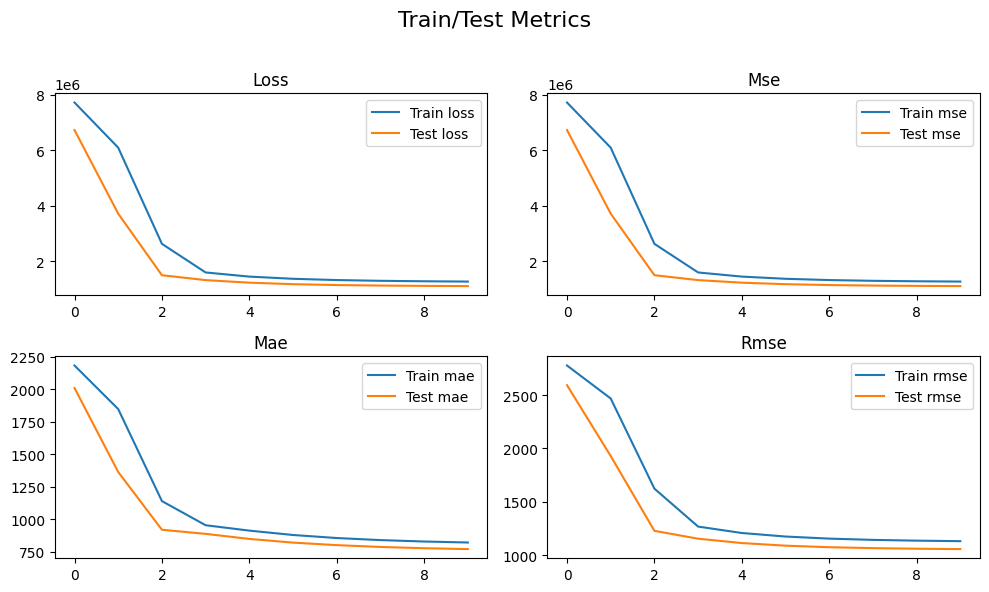

In [29]:
trainer.plot_metrics()